In [1]:
# fundemental modules
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import gc
import time
import pprint
from tqdm.notebook import trange
import sys
import cv2

In [2]:
# display visuals 
from utils import record_videos, show_videos

ModuleNotFoundError: No module named 'utils'

In [3]:
# deep learning modules
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from keras.utils import plot_model
tf.random.set_seed(43)


2023-12-13 22:54:23.182408: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 22:54:23.204530: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 22:54:23.204554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 22:54:23.204567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 22:54:23.208753: I tensorflow/core/platform/cpu_feature_g

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-12-13 22:54:24.891167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 22:54:24.913327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 22:54:24.913423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
# PER

class ReplayBuffer(object):
    """
    * init the values
    * for DQN actions are discrete
    """
    def __init__(self, max_size, min_size, input_shape, n_actions, discrete=True):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.min_size = min_size
        self.discrete = discrete
        self.index = 0
        
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float16)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float16)
        dtype = np.int8 if self.discrete else np.float16
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float16)
        self.terminal_memory = np.zeros(self.mem_size)
        self.priorities = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):

        index = self.mem_cntr % self.mem_size                
        self.state_memory[index] = state
        self.new_state_memory[index] = state_

        #* store one hot encoding of actions, if appropriate
        if self.discrete:
            #* Create an zeros-array size of the number of actions
            actions = np.zeros(self.action_memory.shape[1])
            #* Make 1 the value of performed action
            actions[action] = 1.0
            #* Store in action memory
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action

        #* store reward and if it's terminal info 
        self.reward_memory[index] = reward
        #* we send inverse done info!!!
        self.terminal_memory[index] = 1 - done
        self.priorities[index] = max((self.priorities.max()), 1.0)
        self.mem_cntr +=1
        self.index = self.mem_cntr

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
        
    def get_importance(self, probabilities):
        importance = 1/(self.mem_cntr) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized

    def sample_buffer(self, batch_size, priority_scale=1.0):
        
        if self.mem_cntr >= self.mem_size:
            self.index = self.mem_size
            
        sample_size = batch_size
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(self.index), k=sample_size, weights=sample_probs[:self.index])

        states = self.state_memory[sample_indices]
        actions = self.action_memory[sample_indices]
        rewards = self.reward_memory[sample_indices]
        states_ = self.new_state_memory[sample_indices]
        terminal = self.terminal_memory[sample_indices]

        # samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return states, actions, rewards, states_, terminal, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            error = abs(e) + offset
            clipped_error = np.minimum(error, 1.0)
            self.priorities[i] = clipped_error

In [6]:
#DDQN agent

class DDQNAgent:

    def __init__(self, alpha, gamma, epsilon, obs_shape,
                 batch_size, epsilon_dec, epsilon_end, mem_size, 
                 min_mem_size, learning_rate, replace_target):

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.min_mem_size = min_mem_size
        self.replace_target = replace_target
        self.obs_shape = obs_shape
        self.learning_rate = learning_rate

        self.discrete_action_space = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
        self.n_actions = len(self.discrete_action_space)
        self.action_space = [i for i in range(self.n_actions)]

        self.memory = ReplayBuffer(max_size=self.mem_size, min_size=self.min_mem_size,input_shape=self.obs_shape,
                             n_actions=self.n_actions,discrete=True)
                        
        self.q_eval = self._make_model()
        self.q_target = self._make_model()      #we keep a target model which we update every K timesteps
        self.q_eval.build(input_shape=(None, 128, 64, 4)  )  
        self.q_eval.summary()    
        plot_model(self.q_eval, to_file='model_ddqn.png')

    def _make_model(self):
        
        model = Sequential()
        model.add(Conv2D(32, 8, strides=2, activation="relu"))
        model.add(Conv2D(64, 4, strides=2, activation="relu"))
        model.add(Conv2D(64, 3, strides=1, activation="relu"))
        model.add(Flatten())
        # model.add( Dense(256, input_dim = self.obs_shape[0], activation='relu') )
        model.add( Dense(512, activation='relu') )
        model.add( Dense( self.n_actions))
        model.compile(loss='mse',optimizer= Adam(learning_rate = self.learning_rate),metrics=["accuracy"]) # type: ignore
 
        return model

    def epsilon_decay(self):
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_end \
        else self.epsilon_end

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def update_network_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())
        
    def get_action(self, observation):

        if np.random.random() > self.epsilon: # type: ignore
    
            # observation = tf.convert_to_tensor(observation, dtype = tf.float16)
            observation = tf.expand_dims(observation, axis=0)
            qs_= self.q_eval.predict(observation)
            action_index = np.argmax(qs_)
            action = self.discrete_action_space[action_index]
        else:
            action_index = np.random.randint(0, self.n_actions)
            action = self.discrete_action_space[action_index]
        
        return action, action_index

    def train(self):

        if (self.memory.mem_cntr) < self.min_mem_size:
            return
        #* and ELSE:
        #* sample minibatch and get states vs..
        state, action, reward, new_state, done, sample_indices = \
                            self.memory.sample_buffer(self.batch_size)

        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)

        # state = tf.convert_to_tensor(state, dtype = tf.float16)
        # new_state = tf.convert_to_tensor(new_state, dtype = tf.float16)
        # reward = tf.convert_to_tensor(reward, dtype = tf.float16)
        # done = tf.convert_to_tensor(done)
        # action_indices = tf.convert_to_tensor(action_indices, dtype=np.int8)
        
        #* get the q values of current states by main network
        q_pred = self.q_eval.predict(state)

        #! for abs error
        target_old = np.array(q_pred)

        #* get the q values of next states by target network
        q_next = self.q_target.predict(new_state) #! target_val

        #* get the q values of next states by main network
        q_eval = self.q_eval.predict(new_state) #! target_next

        #* get the actions with highest q values
        max_actions = np.argmax(q_eval, axis=1)

        #* we will update this dont worry
        q_target = q_pred

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        #* new_q = reward + DISCOUNT * max_future_q
        q_target[batch_index, action_indices] = reward + \
                    self.gamma*q_next[batch_index, max_actions.astype(int)]*done

        #* error
        error = target_old[batch_index, action_indices]-q_target[batch_index, action_indices]
        self.memory.set_priorities(sample_indices, error)

        #* now we fit the main model (q_eval)
        _ = self.q_eval.fit(state, q_target, verbose='auto')

        #* If counter reaches set value, update target network with weights of main network
        #* it will update it at the very beginning also
        if self.memory.mem_cntr & self.replace_target == 0:
            self.update_network_parameters()
            print("Target Updated")

        gc.collect()
        K.clear_session()
        self.epsilon_decay()

    def save_model(self, episode):
        print("-----saving models------")
        self.q_eval.save_weights(f"weights/ddqn/q_net-{episode}.h5")
        # self.q_target.save_weights(self.network.checkpoint_file)

    def load_model(self):
        print("-----loading models------")
        self.q_eval.load_weights("q_net-484.h5")
        self.update_network_parameters()

In [2]:
def observation_shape(observation):
    return np.array(np.transpose(observation, (1, 2, 0)))

In [3]:
# envirenment config
 
env = gym.make('racetrack-v0', render_mode='rgb_array')
env.configure({
    'action': {'lateral': True,
            'longitudinal': False,
            'target_speeds': [0, 5],
            'type': 'ContinuousAction'},
        "observation": {
            "type": "GrayscaleObservation",
            "observation_shape": (64, 32),
            "stack_size": 2,
            "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
            "scaling": 1.75,    },
    "other_vehicles": 1,
    'show_trajectories': False,
    'collision_reward': -1,
    'normalize_reward': True,
    
})

/home/o/Documents/thesis/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


(2, 64, 32)
(64, 32, 2)
Environment is setted up.


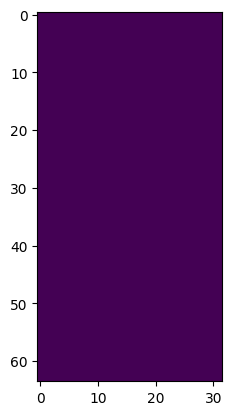

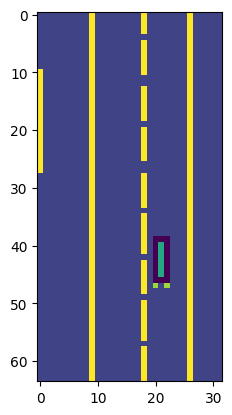

In [7]:
# prints env configs
#* obs is flattened to 1D array for nn

# pprint.pprint(env.config)
(obs, info), done = env.reset(), False

print(obs.shape)
obs = observation_shape(obs) 
print(obs.shape)
print("Environment is setted up.")

plt.imshow(obs[:,:,0])
plt.show()
plt.imshow(obs[:,:,1])
plt.show()



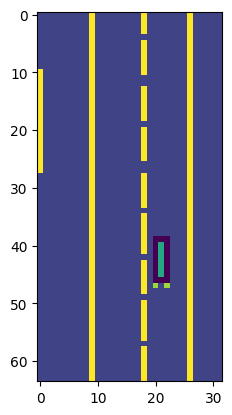

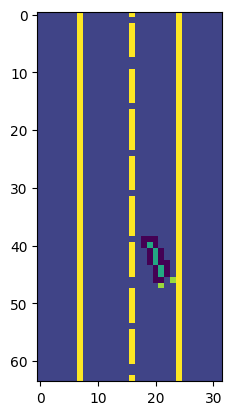

In [8]:
new_observation, reward, done, truncated, info = env.step(action=[1.0,1.0])
new_observation= observation_shape(new_observation)
plt.imshow(new_observation[:,:,0])
plt.show()
image1 = cv2.imwrite("f1.png",new_observation[:,:,0] )
plt.imshow(new_observation[:,:,1])
plt.show()
image1 = cv2.imwrite("f2.png",new_observation[:,:,1] )


In [12]:
# agent config

agent = DDQNAgent(alpha=0.001, gamma=0.9, epsilon=1.0, obs_shape=obs.shape,
                  batch_size=64, epsilon_dec=0.999, epsilon_end=0.05, mem_size=20000,
                  min_mem_size=100, replace_target=100, learning_rate=0.001)

print("Agent is initialized.")


: 

In [11]:
#* basic params for training

best_score = -1000.0
score_history = []


In [12]:
# main loop

#TODO-1: Parameters Tuning

#TODO-6: Actions Shaping

#TODO-7: Pruning

#TODO-8: Tensorboard

env = record_videos(env)

for episode in trange(5000, desc='Test episodes'):
        (observation, info), done = env.reset(), False
        observation = observation_shape(observation)


        done_ = False
        score = 0
        step = 0
        truncated = False
        # env.render()
        while not done_:
            action, action_index = agent.get_action(observation)
            new_observation, reward, done, truncated, info = env.step(action=[action])
            new_observation = observation_shape(new_observation)

            if info["crashed"] == True or info["rewards"]["on_road_reward"] == False or truncated == True:
                done_ = True
                reward = -1.0
            else: done_ = False

            score += reward

            agent.remember(state=observation, action=action_index, done=done_,
                            reward=reward, new_state=new_observation)
            agent.train()

            observation = new_observation
            

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_model(episode)

        print('episode ', episode, 'score %.1f' % score,
               'avg score %.1f' % avg_score)
        print("Exp- value:", agent.epsilon)
        time.sleep(1)

env.close()
# show_videos()

/home/o/.pyenv/versions/3.10.13/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/o/Documents/thesis/highway/videos/trainings/ddqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test episodes:   0%|          | 0/5000 [00:00<?, ?it/s]

-----saving models------
episode  0 score 8.1 avg score 8.1
Exp- value: 1.0
episode  1 score 2.1 avg score 5.1
Exp- value: 1.0
episode  2 score 8.7 avg score 6.3
Exp- value: 1.0
episode  3 score 10.1 avg score 7.3
Exp- value: 1.0
episode  4 score 0.4 avg score 5.9
Exp- value: 1.0
episode  5 score -0.2 avg score 4.9
Exp- value: 1.0
episode  6 score 4.3 avg score 4.8
Exp- value: 1.0
episode  7 score 3.0 avg score 4.6
Exp- value: 1.0
episode  8 score 5.8 avg score 4.7
Exp- value: 1.0
episode  9 score 0.2 avg score 4.3
Exp- value: 1.0


2023-10-16 21:26:38.389074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


2/2 [==============================] - 2s 2ms/step


2023-10-16 21:26:39.196942: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 21:26:39.299997: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2/2 [==============================] - 0s 2ms/step


2023-10-16 21:26:40.207424: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fba9159e0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 21:26:40.207443: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-16 21:26:40.210338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 21:26:40.268298: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 0s 9ms/step - loss: 37.9022 - accuracy: 0.6406
episode  10 score 9.2 avg score 4.7
Exp- value: 0.986090636999001
2/2 [==============================] - 0s 10ms/step - loss: 74.0148 - accuracy: 0.5000
episode  11 score 3.8 avg score 4.6
Exp- value: 0.9782294672887405
2/2 [==============================] - 0s 8ms/step - loss: 41.8184 - accuracy: 0.2500
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 1.1111 - accuracy: 0.2812
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.9002 - accuracy: 0.4219
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.8407 - accuracy: 0.5156
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1454 - accuracy: 0.3594
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1442 - accuracy: 0.3594
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1090 - accuracy: 0.2031
Target U

Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/videos/trainings/ddqn/rl-video-episode-0.mp4
2/2 [==============================] - 0s 8ms/step - loss: 0.1452 - accuracy: 0.3594
episode  179 score 5.1 avg score 5.2
Exp- value: 0.12770540562505597
2/2 [==============================] - 0s 8ms/step - loss: 0.1738 - accuracy: 0.4531
episode  180 score 3.4 avg score 5.1
Exp- value: 0.12668733098884255
2/2 [==============================] - 0s 9ms/step - loss: 0.0761 - accuracy: 0.3750
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1284 - accuracy: 0.4219
Target Updated
2/2 [==============================] - 0s 10ms/step - loss: 0.1480 - accuracy: 0.4531
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1860 - accuracy: 0.4375
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1239 - accuracy: 0.3906
episode  181 score 7.7 avg score 5.1
Exp- value: 0.12467546545785298
2/2 [===============

Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/videos/trainings/ddqn/rl-video-episode-1.mp4
2/2 [==============================] - 0s 8ms/step - loss: 0.2735 - accuracy: 0.3906
episode  309 score 5.8 avg score 8.6
Exp- value: 0.05
2/2 [==============================] - 0s 10ms/step - loss: 0.1393 - accuracy: 0.4062
-----saving models------
episode  310 score 23.3 avg score 8.8
Exp- value: 0.05
2/2 [==============================] - 0s 8ms/step - loss: 0.1975 - accuracy: 0.4688
-----saving models------
episode  311 score 14.3 avg score 8.9
Exp- value: 0.05
2/2 [==============================] - 0s 8ms/step - loss: 0.2447 - accuracy: 0.4844
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.2786 - accuracy: 0.3281
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1604 - accuracy: 0.2656
Target Updated
2/2 [==============================] - 0s 8ms/step - loss: 0.1544 - accuracy: 0.4219
Target Updated
2/2 [========

KeyboardInterrupt: 

In [ ]:
h = np.save("score_history", np.array(score_history))

In [ ]:
print(best_score)
print(avg_score)

In [ ]:
#Evaluating
agent.load_model()

env = record_videos(env)

for episode in trange(10, desc='Test episodes'):
        (observation, info), done = env.reset(), False
        observation = np.array(observation.flatten())

        done_ = False
        score = 0
        step = 0
        # env.render()
        while True:
            action, action_index = agent.get_action(observation.reshape((1,observation.shape[0])))
            new_observation, reward, done, truncated, info = env.step(action=[action])
            new_observation = np.array(new_observation.flatten())

            if info["crashed"] == True or info["rewards"]["on_road_reward"] == False:
                done_ = True
                reward = -1.0
            else: done_ = False

            score += reward


            observation = new_observation

            if done or done_:
                break


        print("Episode: ", episode)
        print("Score: ", score)

env.close()